# Part 1. Install Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## install required packages
!pip install swig
!pip install box2d
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.9/427.9 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d: filename=Box2D-2.3.2-cp310-cp310-linux_x86_64.whl size=2391312 sha256=b4b0580d3f5b44ac4f7b1ec90b2f79e6018db754c35e8468b75ad59aab73a2d0
  Stored in directory: /root/.cache/pip/wheels/eb/cb/be/e663f3ce9aba6580611c0febaf7cd3cf7603f87047de2a52f9
Successfully built box2d
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-9889dfv6
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-9889dfv6
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 1410c340ded1a2fb49b16caf972e55b3d1d6efbb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/

In [3]:
import os
import itertools
import sys
#import time

import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.config import INDICATORS
from finrl.config_tickers import DOW_30_TICKER

check_and_make_directories([TRAINED_MODEL_DIR])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


# Part 2. Data Retrieve

In [4]:
TRAIN_START_DATE = '2010-11-10'
TRAIN_END_DATE = '2022-11-10'
TRADE_START_DATE = '2022-11-10'
TRADE_END_DATE = '2023-11-10'

In [5]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


In [6]:
df_aapl = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['AAPL']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3272, 8)


# Part 3: Data Preprocessing


In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_aapl)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3271, 8)
Successfully added vix
Successfully added turbulence index


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

### Split the data for training and trading

In [9]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

3021
250


In [11]:
train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-11-10,AAPL,11.308571,11.384643,11.198214,9.628132,384227200.0,2.0,0.000000,9.666329,9.548153,0.000000,-66.666667,100.000000,9.628132,9.628132,18.469999,0.000000
1,2010-11-11,AAPL,11.250000,11.371429,11.223214,9.586350,361284000.0,3.0,-0.000937,9.666329,9.548153,0.000000,-66.666667,100.000000,9.607241,9.607241,18.639999,0.000000
2,2010-11-12,AAPL,11.285714,11.303571,10.843929,9.325380,795846800.0,4.0,-0.009287,9.841423,9.185152,0.000000,-100.000000,100.000000,9.513288,9.513288,20.610001,0.000000
3,2010-11-15,AAPL,11.016429,11.090714,10.938214,9.295415,403606000.0,0.0,-0.013939,9.804146,9.113493,0.000000,-79.085410,100.000000,9.458819,9.458819,20.200001,0.000000
4,2010-11-16,AAPL,10.918571,10.985714,10.690000,9.130416,657650000.0,1.0,-0.022739,9.812325,8.973953,0.000000,-110.697755,100.000000,9.393139,9.393139,22.580000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,2022-11-03,AAPL,142.059998,142.800003,138.750000,137.879318,97918500.0,3.0,-0.490040,154.491971,133.364867,43.784873,-90.141031,20.980348,144.396023,152.450566,25.299999,3.945610
3017,2022-11-04,AAPL,142.089996,142.669998,134.380005,137.610825,140814800.0,4.0,-1.100305,154.579703,133.130157,43.651214,-108.444117,28.965228,144.004847,151.956147,24.549999,0.007410
3018,2022-11-07,AAPL,137.110001,139.149994,135.669998,138.147812,83374600.0,0.0,-1.523058,154.640796,132.943023,44.004867,-110.485506,28.965228,143.620319,151.410944,24.350000,0.034185
3019,2022-11-08,AAPL,140.410004,141.429993,137.490005,138.724594,89908500.0,1.0,-1.790906,154.598780,133.059640,44.392656,-80.326744,21.637302,143.222255,150.857319,25.540001,0.039001


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['open'].plot(kind='hist', bins=20, title='open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['high'].plot(kind='hist', bins=20, title='high')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['low'].plot(kind='hist', bins=20, title='low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='open', y='high', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='high', y='low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='low', y='close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['high']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('high')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('low')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('close')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['open'].plot(kind='line', figsize=(8, 4), title='open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['high'].plot(kind='line', figsize=(8, 4), title='high')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['low'].plot(kind='line', figsize=(8, 4), title='low')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part 4. Environment

In [23]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [24]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

Training environment

In [25]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 5. Train DRL agents

### PPO

In [73]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [74]:
%time
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
-----------------------------------
| time/              |            |
|    fps             | 495        |
|    iterations      | 1          |
|    time_elapsed    | 4          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.01759669 |
-----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0009966558 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0001       |
|    loss                 | 0.0959       |
|    n_upd

8m14s

day: 3020, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 8556224.61
total_reward: 7556224.61
total_cost: 8444.23
total_trades: 2992
Sharpe: 0.833

In [75]:
trained_ppo.save('/content/drive/MyDrive/RL_trading' + "/agent_ppo_aapl")

### A2C

In [76]:
#A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
#model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [77]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=200000)

Streaming output truncated to the last 5000 lines.
----------------------------------------
| time/                 |              |
|    fps                | 324          |
|    iterations         | 9100         |
|    time_elapsed       | 140          |
|    total_timesteps    | 45500        |
| train/                |              |
|    entropy_loss       | -3.41        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 9099         |
|    policy_loss        | -0.174       |
|    reward             | -0.027770193 |
|    std                | 7.32         |
|    value_loss         | 0.00308      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 325         |
|    iterations         | 9200        |
|    time_elapsed       | 141         |
|    total_timesteps    | 46000       |
| train/                |             |
|    entropy_

10m21s

day: 3020, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 6097947.90
total_reward: 5097947.90
total_cost: 13392.24
total_trades: 3018
Sharpe: 0.770

In [78]:
trained_a2c.save('/content/drive/MyDrive/RL_trading' + "/agent_a2c_aapl")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DDPG

In [26]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 64, "learning_rate": 0.0001}

model_ddpg = agent.get_model("ddpg", model_kwargs=DDPG_PARAMS)

tmp_path = RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 64, 'learning_rate': 0.0001}
Using cuda device
Logging to results/ddpg


In [27]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=200000)

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 157      |
|    time_elapsed    | 76       |
|    total_timesteps | 12084    |
| train/             |          |
|    actor_loss      | 3.27e+04 |
|    critic_loss     | 5.65e+05 |
|    learning_rate   | 0.0001   |
|    n_updates       | 9063     |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 140      |
|    time_elapsed    | 172      |
|    total_timesteps | 24168    |
| train/             |          |
|    actor_loss      | 1.75e+04 |
|    critic_loss     | 1.68e+05 |
|    learning_rate   | 0.0001   |
|    n_updates       | 21147    |
|    reward          | 0.0      |
---------------------------------
day: 3020, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00

6m35s

#### SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [15]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.00003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 3e-05, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [16]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=200000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 71         |
|    time_elapsed    | 168        |
|    total_timesteps | 12084      |
| train/             |            |
|    actor_loss      | 183        |
|    critic_loss     | 1.83e+04   |
|    ent_coef        | 0.143      |
|    ent_coef_loss   | 18.3       |
|    learning_rate   | 3e-05      |
|    n_updates       | 11983      |
|    reward          | -33.016712 |
-----------------------------------
day: 3020, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 9617639.32
total_reward: 8617639.32
total_cost: 999.00
total_trades: 3020
Sharpe: 0.846
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 71         |
|    time_elapsed    | 338        |
|    total_timesteps | 24168      |
| train/             |            |
|    actor_loss      | 248        |
|    critic_lo

KeyboardInterrupt: ignored

11m5s

### Ensemble

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

env_ensemble_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}
ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_ensemble_kwargs)


In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  13.543283915230381
======Model training from:  2010-11-10 to  2022-11-11
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_2


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------------------------------
| time/                 |                |
|    fps                | 387            |
|    iterations         | 100            |
|    time_elapsed       | 1              |
|    total_timesteps    | 500            |
| train/                |                |
|    entropy_loss       | -1.47          |
|    explained_variance | 5.96e-08       |
|    learning_rate      | 0.0007         |
|    n_updates          | 99             |
|    policy_loss        | -0.0315        |
|    reward             | -0.00061563146 |
|    std                | 1.05           |
|    value_loss         | 0.00016        |
------------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 388          |
|    iterations         | 200          |
|    time_elapsed       | 2            |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       |

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------------------------------
| time/                 |              |
|    fps                | 383          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -1.47        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -0.149       |
|    reward             | -0.016570525 |
|    std                | 1.05         |
|    value_loss         | 0.0155       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 383         |
|    iterations         | 200         |
|    time_elapsed       | 2           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -1.48       |
|    explained_variance 

In [ ]:
unique_trade_date = trade.date.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.1989757399994538


<ipython-input-26-e513a4bce15e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_account_value = df_account_value.append(temp,ignore_index=True)
<ipython-input-26-e513a4bce15e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_account_value = df_account_value.append(temp,ignore_index=True)


<Figure size 1500x500 with 0 Axes>

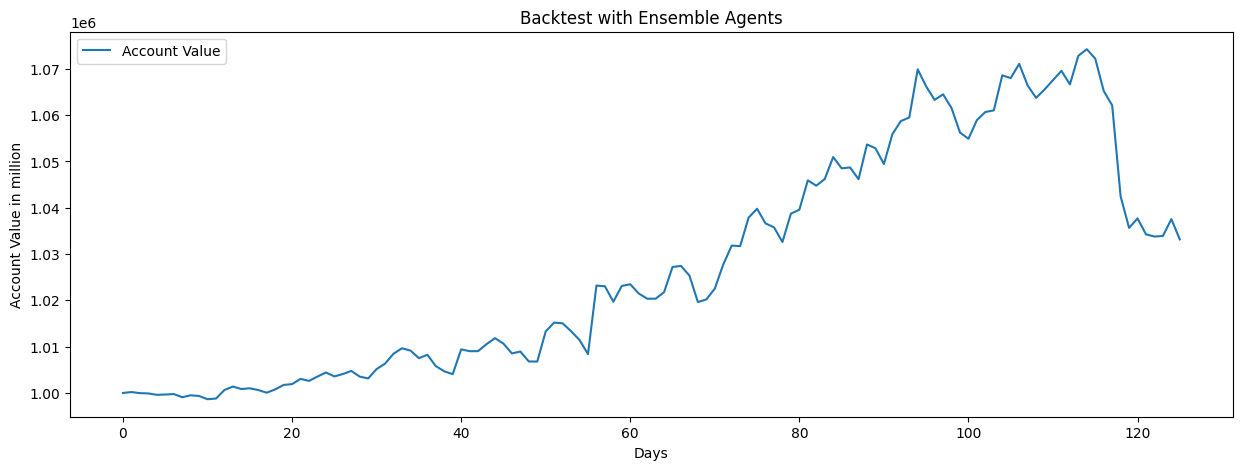

In [ ]:
%matplotlib inline
bt_df = df_account_value[['date', 'account_value']]
bt_df.columns = ['date', 'Account Value']
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
bt_df.plot()
plt.title('Backtest with Ensemble Agents')
plt.xlabel('Days')
plt.ylabel('Account Value in million')
plt.show();

# Part 6. Backtesting

In [111]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [112]:
trade

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-11-10,AAPL,141.240005,146.869995,139.500000,146.053635,118854000.0,3.0,-1.805132,155.154154,132.591369,49.339062,10.610975,4.314266,142.887597,149.775626,23.530001,16.939748
1,2022-11-11,AAPL,145.820007,150.009995,144.369995,148.867905,93979700.0,4.0,-1.135017,155.504467,133.389555,50.857689,66.663881,2.758485,143.276387,149.375171,22.520000,0.724929
2,2022-11-14,AAPL,148.970001,150.279999,147.429993,147.455795,73374100.0,0.0,-0.709710,155.787353,133.713858,50.078479,72.196612,3.360771,143.477461,148.994699,23.730000,0.192024
3,2022-11-15,AAPL,152.220001,153.589996,148.559998,149.206009,89868300.0,1.0,-0.228787,156.240867,133.909522,51.040275,99.098634,10.615700,143.616084,148.708756,24.540001,0.270937
4,2022-11-16,AAPL,149.130005,149.869995,147.289993,147.962952,64218300.0,2.0,0.051451,156.516192,134.148148,50.327870,62.724964,7.311494,143.703345,148.407721,24.110001,0.147789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-02,AAPL,175.520004,177.779999,175.460007,177.336380,77334800.0,3.0,-1.131483,182.802070,166.690497,51.025495,63.709742,0.390528,174.084321,176.447541,15.660000,1.598713
246,2023-11-03,AAPL,174.240005,176.820007,173.350006,176.417572,79763700.0,4.0,-0.772380,182.713694,166.694982,50.133748,32.901525,8.153739,174.146240,176.429564,14.910000,0.142241
247,2023-11-06,AAPL,176.380005,179.429993,176.210007,178.994186,63841300.0,0.0,-0.276688,182.751869,166.680775,52.539942,89.398509,1.950536,174.251102,176.453533,14.890000,0.760682
248,2023-11-07,AAPL,179.179993,182.440002,178.970001,181.580780,70530000.0,1.0,0.321167,183.365620,166.409574,54.804687,136.219330,12.077039,174.579336,176.492814,14.810000,0.739327


In [113]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [114]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

### Backtest agents

In [115]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

hit end!


In [116]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)

hit end!


In [49]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

hit end!


In [57]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym)

hit end!


# Part 7. Plotting

In [87]:
df_dji

,date,close
0,2022-11-10,33715.371094
1,2022-11-11,33747.859375
2,2022-11-14,33536.699219
3,2022-11-15,33592.921875
4,2022-11-16,33553.828125
...,...,...
246,2023-11-03,34061.320312
247,2023-11-06,34095.859375
248,2023-11-07,34152.601562
249,2023-11-08,34112.269531


In [103]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
dji.rename(columns = {'account_value':'DJIA'}, inplace = True)
# dji

In [32]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)

df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)

#df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
#df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)

result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
#result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
#result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [118]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
)
#df_result_ddpg = (
##    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
#)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
)
#df_result_sac = (
#    df_account_value_sac.set_index(df_account_value_sac.columns[0])
#)
result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"],
        #"ddpg": df_result_ddpg["account_value"],
        "ppo": df_result_ppo["account_value"],
        #"sac": df_result_sac["account_value"],
        "dji": dji["close"],
    }
)

In [119]:
col_name = ['A2C', 'PPO','DJIA']
result.columns = col_name

In [120]:
agents = result[['A2C', 'PPO']]

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

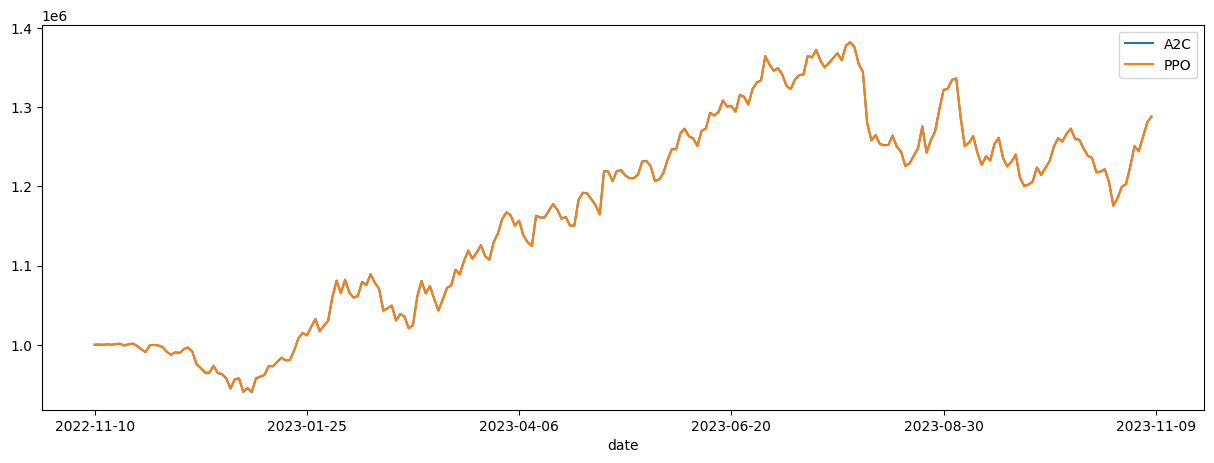

In [121]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
agents.plot()

<Figure size 1500x500 with 0 Axes>

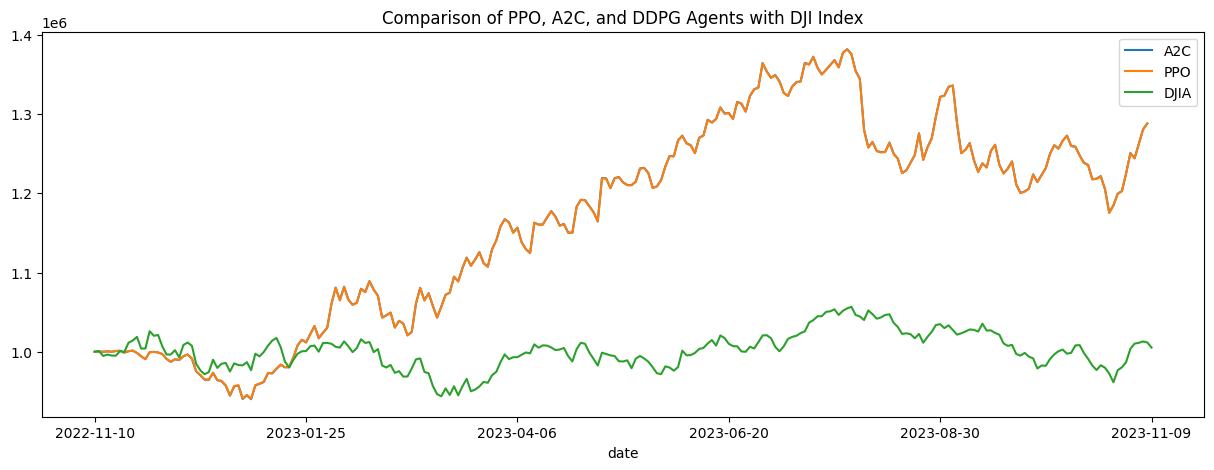

In [122]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title('Comparison of PPO, A2C, and DDPG Agents with DJI Index')
plt.show();

In [123]:
result

,A2C,PPO,DJIA
date,,,
2022-11-10,1.000000e+06,1.000000e+06,1.000000e+06
2022-11-11,1.000267e+06,1.000264e+06,1.000964e+06
2022-11-14,9.999695e+05,9.999698e+05,9.947006e+05
2022-11-15,1.000480e+06,1.000475e+06,9.963681e+05
2022-11-16,9.999677e+05,9.999680e+05,9.952086e+05
...,...,...,...
2023-11-03,1.244299e+06,1.244043e+06,1.010261e+06
2023-11-06,1.262472e+06,1.262210e+06,1.011285e+06
2023-11-07,1.280715e+06,1.280448e+06,1.012968e+06


<Figure size 1500x500 with 0 Axes>

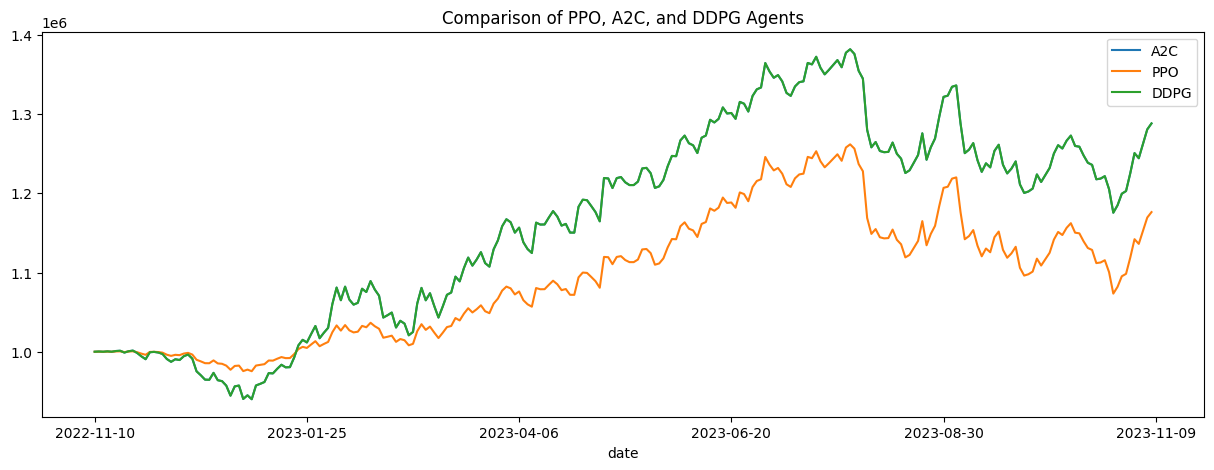

In [ ]:
agent = result[['A2C','PPO', 'DDPG']]
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
agent.plot()
plt.title('Comparison of PPO, A2C, and DDPG Agents')
plt.show();

In [ ]:
result

,PPO,A2C,DDPG,DJIA
date,,,,
2022-11-10,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2022-11-11,1.000109e+06,1.000267e+06,1.000267e+06,1.000964e+06
2022-11-14,9.999875e+05,9.999695e+05,9.999695e+05,9.947006e+05
2022-11-15,1.000197e+06,1.000480e+06,1.000480e+06,9.963681e+05
2022-11-16,9.999868e+05,9.999677e+05,9.999677e+05,9.952086e+05
...,...,...,...,...
2023-11-03,1.136158e+06,1.244237e+06,1.244299e+06,1.010261e+06
2023-11-06,1.152751e+06,1.262407e+06,1.262472e+06,1.011285e+06
2023-11-07,1.169409e+06,1.280648e+06,1.280715e+06,1.012968e+06
